In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
import time
import json
import re

import numpy as np
import matplotlib.pyplot as plt
#!cp "drive/My Drive/kth-master/mu/model_funcs.py" .
from model_funcs import *
from sklearn import metrics

In [3]:
def decode_i(i):
    ''''i is the index as the y vector is encoded
    n is the number of the note e.g. 0 for C, 1 for C#, 2 for D etc.
    q is the quality number, which is -1 for N and
    # 0 for maj, 1 for min, 2 for 7, 3 for hdim, 4 for dim 
    
    This function returns (q,n)'''
    if i<0 or i>60:
        raise ValueError
    if i==0:
        return (-1,-1)
    else:
        q = (i-1)//12
        n = (i-1)%12
        return (q, n)

def encode_i(q, n):
    '''This function does the opposite,
    from quality and note it returns the suitable index
    
    q from 0 to 4 inclusive, -1 means NAN
    n from 0 to 11 inclusive'''
    
    if q==-1:
        if n==-1:
            return 0
        else:
            raise ValueError
    else:
        if n==-1:
            raise ValueError
        return q*12 + n + 1
    

# Jazz chord recognition

### Project in course DT2470 Music Informatics

Simon Falk, simonfal@kth.se

## Summary

In this project I investigated if it's possible to retrieve chord symbols from chroma features by learning from large amounts of annotated data. The dataset used consists of chroma features and chord annotations for 112 jazz songs. I have not chosen this dataset because it's suitable for chord recognition, rather on the contrary, jazz chords are intrinsically hard to classiy (even for the human ear).

## Feature and label extraction

Audio was sampled at 44.1 kHz and then processed by the short-time Fourier transform with a hop size of 2048 frames to give a chromagram with 21.53 chroma vectors per second. (Not done by me, but according to documentation it was done this way.) I will call the set of chroma vectors $X = [x_i^{(1)} x_i^{(2)} \dots x_i^{(12)}]_{i=1 \dots N}$, and $N$ is the total number of chroma vectors for all songs.

The chroma vectors were then logarithmically compressed using $\gamma=10$.

I grouped the different chords into 5 classes:
* major
* minor
* dominant-seventh
* half-diminished
* diminished

These classes have support from jazz music theory and were proposed by the authors (REF) of the dataset. Now, there were a lot of chords in the annotations that had abbreviations like `F#:(3, #5, b7, 11)` or something alike. (The numbers denote inside the parentheses denote intervals from the root of the chord.) Since I both felt I would spend too time writing a string processing algorithm and also that I was unsure how to classify these more exotic chords into the five base classes, I would discard those chords.

Each chord maps to a number from 1 to 60 corresponding to the 12 different keys and the five different chord groups. Aligning everything to the feature rate of the chromas, we get a label vector $y$ of the same length as the feature vector $X$.

In [3]:
pre_path = 'drive/My Drive/kth-master/mu/'
pre_path = ''
dataset_path = 'project_data/JAAH-master/'
features_path = pre_path + dataset_path + 'features/'
annotations_path = pre_path + dataset_path + 'annotations/'


In [4]:
db_file = open(features_path + 'db.json', 'r')
songs = json.load(db_file)
db_file.close()

In [1]:
def flatten_and_align(parts_list):
    '''
    Nested list is flattened into a single list and 
    chord chart syntax is interpreted.
    
    Input: List of different parts of the song,
    each consisting of a dictionary {beats: [], chords: []}
    holding two lists mapping each chord to a time code of the song.
    Output: (t, C)
    where t :    1d numpy array of time codes
    and   C :    1d numpy array of chord symbols (string)
    '''
    t = []
    C = []
    
    for i, part in enumerate(parts_list):
        if len(t) > 0:
            assert part["beats"][0] > t[-1]
        times = part["beats"]
        
        chord_str = "".join(part["chords"])
        measures = re.split('\|{1,2}',chord_str)[1:-1]
        chords = []
        for m in measures:
            chord_set = re.split(' ', m)[:-1]
            if len(chord_set) == 1:
                chord_set = 4 * chord_set
            elif len(chord_set) == 2:
                chord_set = 2 * [chord_set[0]] + 2 * [chord_set[1]]
            chords.extend(chord_set)
            
        if len(times) != len(chords):
            print("Part " + str(i) + " discarded")
        else:
            t.extend(times)
            C.extend(chords)
    
    t = np.array(t)
    C = np.array(C)
    return t, C


def frame_chords(n_of_frames, feature_rate, time_vector, chord_vector):
    '''
    List of chords and time codes are aligned to the time codes related to
    the rate with which features are given.
    
    Input: (n_of_frames, feature_rate, time_vector, chord_vector)
    where n_of_frames  :    length of feature sequence,
          feature_rate :    # features per seconds,
          time_vector  :    list of time codes,
          chord_vector :    list of chord symbols. 
    The two lastmentionened have the same length.
    
    Output: list of chords symbols having same length as feature sequence.
    
    '''
    C_t = []
    pointer = 0
    
    for n in range(n_of_frames):
        t = n*1.0/feature_rate
        t_mid = (n+0.5)/feature_rate
        
        if np.abs(time_vector[pointer] - t_mid) <= 0.5/feature_rate:
            C_t.append(chord_vector[pointer])
            pointer += 1
        else:
            if pointer == 0:
                C_t.append('N')
            else:
                C_t.append(chord_vector[pointer-1])
    return C_t


def number_chords(chord_vector):
    '''
    Translate a sequence of chord symbols into sequence of integers
    where we have defined a map between chords and numbers
    
    Input: list of chords
    Output: list of indices
    '''
    note_names = ['C','C#','D','Eb','E','F','F#','G','G#','A','Bb','B']
    note_dict = {
        'C' : 0,
        'C#' : 1,
        'Db' : 1,
        'D' : 2,
        'D#' : 3,
        'Eb' : 3,
        'E' : 4,
        'F' : 5,
        'F#' : 6,
        'Gb' : 6,
        'G' : 7,
        'G#' : 8,
        'Ab' : 8,
        'A' : 9,
        'A#' : 10,
        'Bb' : 10,
        'B' : 11
    }
    qual_dict = {
        'maj7' : 0,
        'maj7/3' : 0,
        'maj6' : 0,
        'maj9' : 0,
        'min' : 1,
        'min7' : 1,
        'min6' : 1,
        'minmaj7' : 1,
        'min9' : 1,
        '7' : 2,
        '9' : 2,
        '7/5' : 2,
        'aug' : 2,
        'hdim7' : 3,
        'dim7': 4,
        'dim' : 4
    }
    indices = []
    count_labeled = 0
    for chord_str in chord_vector:
        if re.match('N', chord_str):
            indices.append(0)
            count_labeled += 1
        else:
            splitted = chord_str.split(":")
            if len(splitted) == 1:
                quality = 0
            else:
                if splitted[1][0] == '(':
                    indices.append(0)
                    continue
                else:
                    quality = qual_dict[splitted[1].split("/")[0]]
            count_labeled += 1
            try:
                note = note_dict[splitted[0]] + 1
                indices.append(note + quality*12)
            except KeyError:
                indices.append(0)
            
    labeled_ratio = count_labeled/len(chord_vector)
    return indices, labeled_ratio


def compress_log(values, gamma=100):
    '''values is a np array, 
    gamma is the compression constant'''
    return np.log(np.ones(values.shape) + gamma*values)

In [7]:
song_data = []
X_adjusted = np.zeros((0,12))
y = np.zeros((0))
starting_points = []
idx = 0
for song_obj in songs:
    song_name = song_obj['nnls_chroma']['path'].split('.')[0]
    step_size = int(song_obj['nnls_chroma']['step_size'])
    sample_rate = int(song_obj['nnls_chroma']['sample_rate'])
    feature_rate = sample_rate * 1.0 / step_size
    
    song_dict = {
                "song_name" : song_name,
                "step_size" : step_size,
                "sample_rate" : sample_rate,
                "feature_rate" : feature_rate
    }
    print(str(idx) + " " + song_name)
    
    if os.path.isfile(features_path + song_name + '.csv'):
        chroma_file = open(features_path + song_name + '.csv')
        chroma_raw = chroma_file.readlines()
        chroma_file.close()
    
    song_dict["starting_point"] = X.shape[0]
    
    song_chroma = []
    for i in range(len(chroma_raw)):
        song_chroma.append([
                            float(ele) for ele in 
                            chroma_raw[i].strip().split(',')[1:]
        ])
    
    song_chroma = compress_log(np.array(song_chroma), gamma=10)
    
    
    
    # Collect annotations
    if os.path.isfile(annotations_path + song_name + '.json'):
        json_file = open(annotations_path + song_name + '.json')
        noted_obj = json.load(json_file)
        json_file.close()
     
    t, C = get_chords_from_noted(noted_obj.pop("parts"))
    if len(t) > 2:
        frames_retrieved = len(t)
        t_of_last_retrieval = t[-1] 
        frames_used = int(t[-1]*feature_rate)-2 
        F = frame_chords(frames_used, feature_rate, t, C)
        chord_indices, ratio = indexize_chords(F)
        y = np.concatenate((y, np.array(chord_indices)))
    else:
        frames_retrieved = 0
        frames_used = 0
    
    song_dict.update(noted_obj)
    song_data.append(song_dict)
    
    X_adjusted = np.concatenate((X_adjusted, song_chroma[:frames_used]))
    
    idx += 1
    


0 i_gotta_right_to_sing_the_blues
Stopped at part 3/4
1 black_water_blues
Stopped at part 2/5
2 ko-ko(ellington)
Stopped at part 6/7
3 haig_and_haig
Stopped at part 9/11
4 blues_for_alice
Stopped at part 6/7
5 for_dancers_only
Stopped at part 6/7
6 honeysuckle_rose
Stopped at part 1/6
7 maple_leaf_rag(hyman)
Stopped at part 0/1
8 maple_leaf_rag(braxton)
Stopped at part 0/2
9 in_a_mellotone
Stopped at part 3/4
10 airegin
Stopped at part 5/8
11 giant_steps
Stopped at part 9/11
12 harlem_congo
Stopped at part 8/9
13 bags_groove
Stopped at part 0/9
14 minor_swing
Stopped at part 1/10
15 work_song
Stopped at part 5/6
16 blues_in_the_closet
Stopped at part 4/5
17 honky_tonk_train
Stopped at part 1/11
18 i_cant_believe_you_are_in_love_with_me
Stopped at part 0/7
19 bikini
Stopped at part 1/5
20 dinah_red_nichols
Stopped at part 3/4
21 i_got_rhythm
Stopped at part 8/15
22 moanin
Stopped at part 2/11
23 weather_bird
Stopped at part 1/10
24 tricroism
Stopped at part 1/7
25 moten_swing
Stopped at

In [9]:
# Throw away data labeled as NAN
nan_idx = np.where(y==0)[0]
y = np.delete(y, nan_idx)
X_adjusted = np.delete(X_adjusted, nan_idx, axis=0)

# Divide into training and test sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X_adjusted, y, test_size=0.2, random_state=19)


# HMM - use consecutive frames

size = 200000
X_hmm = X_adjusted[50000:50000+size]
y_hmm = y[50000:50000+size]
X_train, X_test, y_train, y_test = train_test_split(
        X_hmm, y_hmm, test_size=0.2, shuffle=False)


227469


## Method 1 - using class mean distance

This method is taken from chapter 5.2 in Müller's textbook and makes use of templates, which are supposed to hold the correct representation of a particular chord. The templates used here will be inferred by taking the mean of all chromas belonging to a certain class (having a certain value of $y$ in the range 1 to 60).

We try to mitigate the fact that there are a lot of F chords and only a few F# chords to learn from, by shifting all chords down to C by cyclic permutation, before taking the mean. This is common practice in chord recognition literature. We thus get one mean for major chords, one for minor chords and so on. Before moving on we also have to permute each of the mean vectors back to all 12 keys, resulting in 60 template vectors ${t_1, t_2, \dots t_{60}}$. We have also normalized each template vector so that the sum over all 12 components is 1. For future reasons define the 60x12 matrix $\mathbf{T}$ through $T^T=[t_1 | t_2 | \dots | t_{60}]$

Müller proposes that we for classification compute the cosine similarity $$s(x,y) = \frac{x\cdot y}{\|x\| \cdot \|y\|}$$ between each 12-dimensional test vector $v$ and each of the templates vectors, and then assigns $v$ to the class $\hat{y}$ for which this similarity value is largest. To simplify computations we rewrite this in matrix notation as $$\hat{y} = \arg \max_i [\mathbf{T} v^T]_i$$

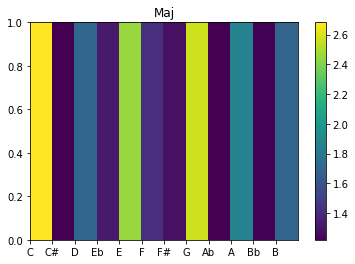

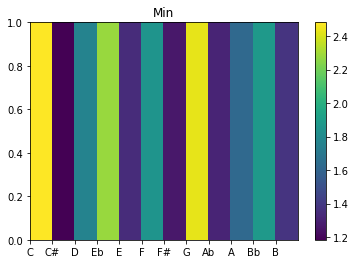

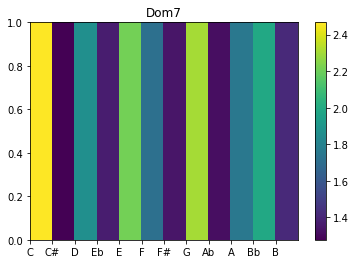

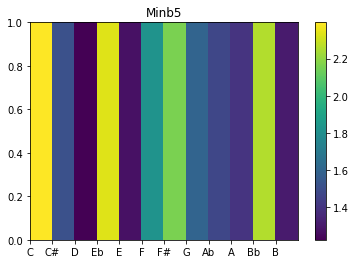

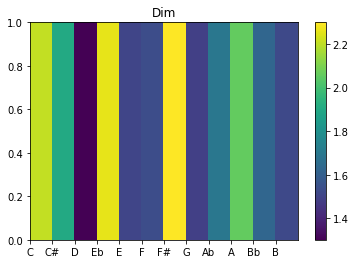

In [123]:
# Produce y vector per quality
# and modify X matrix so all chords are in C

y_qual = np.zeros_like(y_train)
X_shifted = np.zeros_like(X_adjusted)

for i in range(61):
    q, n = decode_i(i)
    # Index set of members of specific class
    idx = np.where(y_train == i)[0]
    if len(idx) == 0: # if there is no data for that chord
      continue
    X_idx = np.take(X_train, idx, axis=0)
    #add it to the quality-sorted 3-matrix, roll back to c
    y_qual[idx] = q
    
    X_shifted[idx] = np.roll(X_idx, -n)



# compute mean and standard deviation
means_flat = np.zeros((61,12)) # size [QxN + 1][12]
stds_flat = np.zeros((61,12))
covs = np.zeros((61,12,12))


for q in range(0,5): # disregard NAN class
    idx = np.where(y_qual == q)[0]
    X_idx = np.take(X_shifted, idx, axis=0)
    means_flat[encode_i(q, 0)] = np.mean(X_idx, axis=0)
    stds_flat[encode_i(q, 0)] = np.std(X_idx, axis=0, ddof=1)
    covs[encode_i(q, 0)] = np.cov(X_idx, rowvar=False)
    
    quals = ["Maj","Min","Dom7","Minb5","Dim"]
    plt.title(quals[q])
    plt.pcolormesh([np.mean(X_idx, axis=0)])
    plt.savefig("img/"+quals[q]+"chroma.png")
    plt.colorbar()
    
    plt.xticks(np.arange(12), ['C','C#','D','Eb','E','F','F#','G','Ab','A','Bb','B'])
    plt.show()
    
    for n in range(1, 12):
        # roll means and std over all notes
        i_current = encode_i(q, n)
        i_base = encode_i(q, 0)
        means_flat[i_current] = np.roll(means_flat[i_base], n)
        stds_flat[i_current] = np.roll(stds_flat[i_base], n)
        covs[i_current] = np.roll(covs[i_base], n)


In [126]:
## This is similarity matching with inferred templates

means_factor = np.reciprocal(np.linalg.norm(means_flat, axis=1))
means_factor[0] = 0
labels = np.zeros_like(y_train)
for n in range(len(y_train)):
    labels[n] = np.argmax(np.multiply(means_factor,means_flat@X_train[n].T))

<ipython-input-126-8921e0761ff6>:3: RuntimeWarning: divide by zero encountered in reciprocal
  means_factor = np.reciprocal(np.linalg.norm(means_flat, axis=1))


0.18892705041901361


array([[1588,    6,   23,   54,   65,  146,   13,  387,   43,   26,   18,
          39],
       [  27, 1808,   14,   32,   53,   64,  291,   15,  255,   37,   49,
          44],
       [   3,    5,  916,    9,   14,   16,   13,  282,    0,   70,   27,
           9],
       [ 168,  117,   46, 4457,   44,   85,  143,  180,  655,   18,  458,
         162],
       [   0,    0,    0,    0,    3,   13,    0,    0,    0,    0,    0,
           0],
       [ 328,  106,  109,   70,   47, 2234,   10,   52,  117,  127,  368,
          10],
       [   3,   74,    3,   22,    2,   11,  303,   11,   10,   27,   18,
          16],
       [ 133,   13,  185,   45,   39,   17,   11, 1105,   15,   32,   25,
          42],
       [  77,  185,   21,  374,   28,   63,   24,   52, 2946,   13,   68,
          34],
       [   7,    3,   17,    0,   38,    4,    6,    6,    2,  254,    0,
          18],
       [ 131,  160,  178,  380,   35,  473,   93,  186,  110,   57, 3184,
          12],
       [   3,   18,  

In [ ]:
print(metrics.accuracy_score(y_train, labels))
#metrics.confusion_matrix((y_train-1)//12, (labels-1)//12)
metrics.confusion_matrix(y_train, labels)[1:13,1:13]

0.34366612399348795


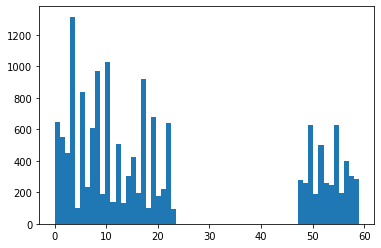

In [88]:
# Similarity matching with triad templates
triad0 = np.array([1,0,0,0,1,0,0,1,0,0,0,0]) # maj
triad1 = np.array([1,0,0,1,0,0,0,1,0,0,0,0]) # min
triad2 = np.array([1,0,0,1,0,0,1,0,0,0,0,0]) # dim

tt = np.zeros((60,12))

for i in range(60):
    if i<12 or (i>=24 and i<36):
        tt[i] = np.roll(triad0,i%12)
    elif (i>=12 and i<24) or (i>=36 and i<48):
        tt[i] = np.roll(triad1,i%12)
    elif i>=48 and i<60:
        tt[i] = np.roll(triad2,i%12)
        
labels = np.zeros_like(y_test)
correct = 0
total = 0
qual_groups = {0:0, 1:1, 2:0, 3:1, 4:2}
correct_labels = []
for n in range(len(y_test)):
    if y_test[n] != 0:
        total += 1
    labels[n] = np.argmax(tt@X_test[n].T)
    if n%100==0:
        pass
        #print(y_test[n],labels[n] + 1)
    if (y_test[n]-1)//12 == qual_groups[labels[n]//12]:
        correct += 1
        correct_labels.append(labels[n])
        #print(y_test[n],labels[n] + 1)
        
plt.hist(correct_labels, bins=60)
print(correct/total)

(array([168., 170., 299., 160., 183., 120.,  83.,  76.,  53.,  45.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

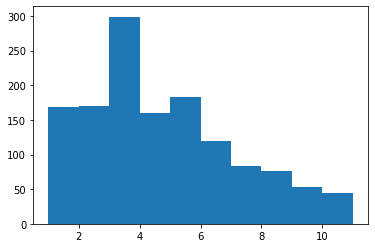

In [103]:
intervals = np.abs(np.argsort(X_test)[:,1]-np.argsort(X_test)[:,0])
y_test_gr = (y_test-1)//12
idx = np.where(y_test_gr==4)
plt.hist(intervals[idx])

## Method 2 - with a HMM model

A Hidden Markov Model (HMM) is proposed in Müller's textbook as another solution to the chord recognition problem. In chaper 5.3 he suggests modelling the chord classes as hidden states and chroma expressions as observations. This HMM reflects both the dependence of the previous chord for estimating the next, and that the true state of a particular chord is hidden and is only seen through chromagrams. 

There are different methods for learning the HMM parameters $\mathbf{A}$, $\mathbf{B}$ and $\mathbf{\pi}$. Firstly, regarding $\mathbf{A}$ (the matrix of transmission probabilities), one simple method is to count bigrams - i.e. the number of times one chord comes after another in the annotations. Secondly, we would want to model our observation space as a multivariate gaussian distribution, making use of the class means we calculated for Method 1. The covariance matrix can be limited as to making the off-diagonal elements zero - assuming independence among regressors. Something that is certainly improbable, just because playing a note would influence the chroma components of all its harmonics. 



In [111]:
def count_bigrams():

    trans_mat = np.zeros((5,60))

    for n in range(len(y_train)-1):
        i = (int(y_train[n]) - 1)//12
        j = int(y_train[n+1]) - 1

        if i<0:
            continue

        trans_mat[i][j] += 1

    trans_mat = trans_mat/trans_mat.sum(axis=1)[:,None]
    trans_matazz = np.zeros((60,60))

    for i in range(60):
        trans_matazz[i] = np.concatenate((np.roll(trans_mat[i//12,:12],i%12),
                                         np.roll(trans_mat[i//12,12:24],i%12),
                                         np.roll(trans_mat[i//12,24:36],i%12),
                                         np.roll(trans_mat[i//12,36:48],i%12),
                                         np.roll(trans_mat[i//12,48:60],i%12)))



In [116]:
from hmmlearn.hmm import GaussianHMM

startprob = np.random.uniform(1/60-1/120,1/60+1/120,(60))
startprob = startprob/np.sum(startprob)
print(means_flat.shape)
print(stds_flat.shape)

model = GaussianHMM(n_components=60,
                    covariance_type='diag',
                    init_params='',
                    params=''
                   )


(61, 12)
(61, 12)


In [117]:
model.transmat_ = trans_matazz
model.means_ = means_flat[1:]
model.covars_ = stds_flat[1:]
model.startprob = startprob

In [105]:
model.fit(X_train)


GaussianHMM(init_params='', n_components=60, params='')

In [108]:
hmm_labels = model.decode(X_test)[1]
print(metrics.confusion_matrix(y_test-1, hmm_labels)[1:13,1:13])
metrics.accuracy_score(y_test-1, hmm_labels)

[[420   6  12   9   7  66   5 111   8   7   7  25]
 [  0  12   0   0   0   0   0   0   0   0   0   3]
 [  1  11 423   0   5  17  17  63   0  44  26 332]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   2   3   1 282   1   3   3   4  26   0  40]
 [  0   1   0   0   3  36   0   0   5   0   0  12]
 [  0  48  11   1   1   0  56   1   8   2   1  10]
 [  7   0   9   1   0   0   1 227   0   0   4  53]
 [  0   0   0   1   0   0   0   0  24   0   0   0]
 [ 34  24  60  12 117  13  16  12  10 526   4 203]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  9  14  97   4  43   4  11  46  14  63   5 412]]


0.17786104693751056

## Use KMeans to cluster chroma vectors



In [ ]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=12, random_state=19).fit(X_adjusted)



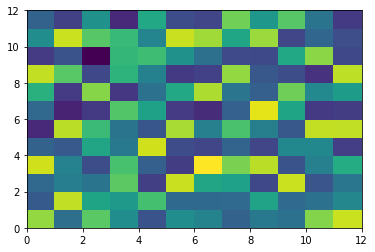

In [ ]:
plt.pcolormesh(clusters.cluster_centers_[0:16].T)

In [ ]:
for pt in range(0,len(X_adjusted),100):
    if clusters.predict([X_adjusted[pt,:]])[0] == 0 and y[pt] != 0:
        print((y[pt]-1)//12,(y[pt]-1)%12)


2.0 5.0
1.0 3.0
1.0 8.0
1.0 0.0
2.0 5.0
2.0 5.0
1.0 0.0
2.0 10.0
0.0 10.0
2.0 0.0
1.0 0.0
0.0 10.0
2.0 5.0
2.0 10.0
2.0 5.0
2.0 3.0
1.0 0.0
1.0 0.0
1.0 7.0
0.0 5.0
2.0 0.0
1.0 0.0
2.0 10.0
1.0 0.0
2.0 3.0
0.0 3.0
2.0 10.0
0.0 3.0
0.0 3.0
0.0 8.0
1.0 5.0
2.0 8.0
2.0 5.0
2.0 10.0
2.0 3.0
0.0 8.0
2.0 3.0
1.0 10.0
0.0 8.0
0.0 10.0
0.0 11.0
2.0 7.0
1.0 10.0
0.0 3.0
2.0 10.0
1.0 5.0
0.0 3.0
0.0 3.0
0.0 3.0
0.0 3.0
2.0 10.0
0.0 3.0
2.0 6.0
0.0 3.0
0.0 3.0
0.0 10.0
2.0 0.0
1.0 0.0
2.0 3.0


In [102]:
## This is Naive Bayes

from scipy.stats import norm
X_test = X_test[:1000]
y_test = y_test[:1000]
test_size = X_test.shape[0]
print(test_size)
labels = np.zeros((test_size))
pt_i = 0
for x in X_test:
    probs = []
    for q in range(5):
        for n in range(12):
            i = 1 + 12*q + n
            likelihood = np.sum([norm.logpdf(x[d], 
                                             loc=means_flat[encode_i(q,n)][d], 
                                             scale=stds_flat[encode_i(q,n)][d][d]) for d in range(12)])
            print(likelihood)
            prior = len(np.where(y_test==i)[0])/len(y_test)
            if likelihood>10**-7 and prior>10**-7:
                prob = np.log(likelihood) + np.log(prior)
            else:
                prob = -np.inf
            probs.append(prob)
    labels[pt_i] = np.nanargmax(probs) + 1 # account for N/N
    pt_i += 1
    if pt_i%100==0:
        print(100*pt_i/test_size)



1000
-20.502164395347567
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.315378138343306
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.911459702010802
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.799400481385767
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.145073977379493
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.486634141767862
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.610559380055342
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.742290710534704
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.477426617501756
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.523490745682906
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.54663328205994
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.930683735068893
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.811920128054883
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.477648887569373
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.836955102639923
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.941337626521143
nan
nan
nan
nan


-20.051149769111515
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.075248401129134
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.21069785982683
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.60892436689587
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.711115340065334
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.714957999001435
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.80534271328397
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-27.521960102828295
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.001518605077578
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-24.021746725854076
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.86873030348741
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.82752111822165
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.184012188061587
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.306671643528976
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.554522445226134
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.049668931820808
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.699465113659617
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.45089872448459
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.612270073658744
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.376815324515942
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.032573947715573
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.533661454526445
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.091231067499027
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.753732657648268
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.665756013309556
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.848642170259232
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.076720657573166
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.390770569480303
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.09825823985539
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.934035167848588
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.506813368118404
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

-22.2467270641534
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.285171624901793
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.702834836731025
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.788243276528558
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.952801112642174
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.885122834090946
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.817186092048843
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.438608774329413
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.22082028365529
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.653045671296525
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.738798483551065
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.12988191131836
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.09807723604196
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-24.129567378244538
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.693535354323448
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.907108765596508
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.246184252030314
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.412343122901255
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.40891693795396
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.905363936423704
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.209136908441177
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.946994269806392
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.492174686373826
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.66743645329352
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.83712005701177
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.043517800159105
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.50020260575247
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.04641675151039
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.56876034583003
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.036908645752234
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.322110268341262
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.14

nan
nan
nan
nan
nan
-25.448362871417974
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.048165289544812
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.639894865562773
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.088706001345045
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.632352638445077
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.641397202742798
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.026076644664272
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.68582328351611
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.851428497214055
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.276280876486926
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.03389954149543
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.844788113912546
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.64141279797243
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-24.001846635505903
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.43151075942357
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.332424214980403
nan


nan
nan
nan
nan
nan
nan
-21.55074745459023
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.809921703644996
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.542799695857312
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.697748930659486
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.553656549540992
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-24.486132370673065
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.068161970547486
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.580550957897888
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.689251278312607
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.66380004595704
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.262684001914167
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.98025973457192
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.61283106449579
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-24.19754926175183
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.48486514459134
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.58684223577324
nan

nan
nan
nan
-22.430034283317028
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.829578671958654
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.856784711456832
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.539921576846695
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.569285563621314
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.35791626527837
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.35455938794118
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.620689176182026
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.72008921629764
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.15334891206602
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.359257890029387
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.396541272966893
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.7781606438107
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.05934872247723
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.48534994950868
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.162459659682447
nan
nan
nan
nan


nan
nan
nan
nan
-19.902062191465408
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.924587320487475
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.526594936181656
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.511255756084076
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.196507150615606
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.358068356176297
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.77591412403857
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.158437309709782
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.36453671249719
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.673435744169648
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.683672277703177
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.130148098689446
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.075176505431354
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.1076119622294
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.612112642941582
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.846272809039412
nan
nan


nan
nan
-22.56509216955704
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.961272177712342
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.007133121110694
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.127270004730654
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.490323508919047
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.960830875203758
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.108609206116466
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.995251449239966
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.25785353612739
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.00692634553115
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.72787104160718
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.159935244102543
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.870985716919744
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-30.910385103382804
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-24.18823279281533
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-25.41076102998129
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.949095429601517
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.550122119140923
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.72214569145554
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.709507606503365
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.731489241430854
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.334032332162586
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.667273095907166
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.856193685684783
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.252890422372655
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.50733781638272
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.90212328110029
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.974259627443057
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.47092040760709
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.871893309301665
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.0708947877593
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1

nan
nan
-17.150561940436102
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.87969434170435
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.739519820887853
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.567007558362626
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.7936988730933
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.59478723668353
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.96689918384771
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.487512708981534
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.37662917371788
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.545821207304158
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.487779638300754
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.399891400166528
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.238323552078164
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.81806636830216
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.89300768030532
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.596273499742228
nan
nan
nan
nan
nan


nan
nan
nan
-18.598909824546634
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.26367622897497
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-26.30589587458238
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.81142151655479
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.288734537438586
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.94946048318783
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.32333332589951
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.546237393399203
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.31122925269964
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.129903769253687
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.122456089408065
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.766071193984875
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.353281219200234
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.149691981547956
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.862715262529374
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.41112735049505
nan
nan
nan
nan

nan
nan
nan
nan
-20.527733304913347
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.87164812827031
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.679668692675154
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.59770080791215
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.835546802053706
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.642985851085777
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.428036171033263
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.70097856069994
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.754713827776353
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.761819066891118
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.304293791275473
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.50884997475655
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.490814312365966
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.337794588925334
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.73666339222896
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.937635384289099
nan
nan
n

-19.694381615909595
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.512698721592306
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.79097760853351
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.746795717820024
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.959558607802993
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.990908818147087
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.52541789666629
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.405473893618684
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.506508536836503
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.319872974175837
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.58527760482181
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.02268501855546
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-13.473910477643386
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.54013187997486
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.12134108351379
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.002937376672616
nan
nan
nan
nan
nan
nan
na

-20.4474609143817
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.548105612481628
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.11587912372496
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.09507942851319
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.48042978603991
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.000673816023298
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.567023392319026
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.616667249035682
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.479548883383092
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.604978502840066
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.23771440469503
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.6480286389903
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.85476493807326
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.558704125761881
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.79547127735684
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-25.377678509143134
nan
nan
nan
nan
nan
nan
nan
na

nan
-22.53901389358119
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.890311217459681
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.141160833399947
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.964913316223555
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.67176195509132
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.69452649443877
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.062987048483233
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.395775941567557
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.631723520627238
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.872202065397797
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.544489534280427
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-25.75582619167043
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.17220657200248
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.760029104818212
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.90790142880007
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.486031305722197
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
-19.93391798735479
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.046832411882903
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.040106365570484
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.507355117646558
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.735270425591647
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.08605284486378
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.5733809603759
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.10919841321418
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.394236375171463
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.186467534174025
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.179815940102507
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.186828000938636
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.356063030742387
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.74940288561273
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.32999142545565
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.818064322788894
nan

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.700319377444476
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-13.894237780130116
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.062320736694325
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.27874453641612
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.697354399790875
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.581139198018814
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.511365352042805
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.178335015046628
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.020830935242763
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.105083404692845
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.547699713214573
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.936821019476554
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.95662926847415
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.225042667553897
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.69627493098019
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
nan
nan
nan
nan
nan
-18.081616648545793
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.360604575433705
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.44560301941096
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.367334187264337
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.17069200319208
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.786518069827675
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.34237739176889
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.851192132298863
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.360394712908676
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.821037851166473
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.33605355942089
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.539425822696375
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.9317257926898
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.180440124761784
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.089106666135525
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.448534779121406
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.39871403558544
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.030769439153426
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.947879661669045
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.139375030697583
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.99498621854056
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-25.840068623708248
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.8216826394532
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.79806007253851
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.26056274983153
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.365229663766044
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.43729614439354
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.95351865005406
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.263715290164882
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.639643319895786
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.552096871349004
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.929340276291
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.200996855931358
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.44083787087988
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.37077176012912
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-24.106687939790454
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.53869229455001
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.07169752019349
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.153066858524618
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.66696660141678
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.386930318556796
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.35633741491737
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.39297681512433
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.921783772773953
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.240085403010163
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.0607188694499
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.71323838

nan
nan
nan
nan
nan
-21.275335533939067
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.985989797488056
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.824340415492387
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.13835391875008
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.151025115760117
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.27638562856384
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.405055230329527
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.417022631925867
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.190849689060048
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.880427591779151
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.181338211576705
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.459766803297416
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.778649848545534
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.476473732676475
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.383444065681363
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-25.241169425451293
na

nan
nan
nan
-17.351873514602417
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.39160039710469
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.307253056637588
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.29445681841667
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.154361037547684
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.251264274100345
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.71255223119645
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.421206300882865
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.90476037381391
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.522207644266732
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.387415755506726
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.96898376209783
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.745798822569952
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.592911846921254
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.229035851438184
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.823631498782374
nan
nan
nan
n

nan
-21.350851509712207
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.8426701692189
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.048674417985552
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.5288765485228
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.51877070328915
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.937582107223218
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-29.48078926805354
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.9355333291788
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-24.16656715684983
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.64219967913558
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.41726257812176
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-26.943200226999164
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.5998510673393
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-24.361874057096845
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.715783102503643
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.627742156437748
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
-23.724005949237146
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.84409947821892
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.98116608816134
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.72643143207663
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.506660843767662
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.33911013706412
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-25.337590171353522
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.74607156406686
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.060454794174447
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.279842585903737
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.641873435580376
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.159046585611044
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.214173230446608
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.449095072940406
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.40062468452155
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.60408509446739
nan

nan
nan
nan
nan
nan
nan
-20.746819143260993
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.17799531454532
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.809650738086045
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.603426103884562
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.006360187594964
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.186222908591333
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.512383181023832
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.787583044620524
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.556121625114834
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.18482858370813
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.361545035964603
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.122506520162823
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.63774350686783
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.88092279606138
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.66386316625547
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.264241592503335
n

nan
nan
nan
nan
nan
nan
nan
-15.901851423061455
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.140473265358025
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.818871871716162
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.60887955421149
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.207076499866545
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.543033091737865
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.09248997958342
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.82427874812156
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.746511195964647
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.715429057588963
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.146616065625963
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.60977372122783
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.603567109823135
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.749654978274613
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.752534410150574
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.381505002216

nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.640740059735524
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.268840772760267
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.978168050309204
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.181386641860406
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.354951965124073
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.05685032679172
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.110215530893292
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.460745917991545
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.521097945205348
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.083150158334924
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.23450449355899
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.41426501684356
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.702539884236845
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.797708846621042
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-25.061545884020095
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.739

nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.978369185079586
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.316667754961152
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.979085139726518
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.57561261994838
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.244421250963644
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.388478949916278
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.15248808079359
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.58923393025188
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.115080813261525
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.3136807973114
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.191888264411876
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.17937756425837
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.70593377902942
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.448842926825158
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.301526079434204
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.2399840

-17.92773883556445
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.311197301590518
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.175604414200826
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.158290455385277
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.05556243793231
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.798018676209367
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.667889776548066
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.94546286560551
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.334560501391017
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.170519848445153
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.14409178974938
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.991194687301032
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.996614475721117
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.938144865490596
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.781496766716874
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.888624866417615
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.905285940818114
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.536816624424997
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.7253110986751
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.934608803957843
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.2544967332721
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.401741679917606
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.207822773982564
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.38211859176782
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.0492709534681
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.33735528074508
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.87216887580459
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.45743396408237
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.568900135654072
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.82603423982935
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.74983384815223
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.913530781220

nan
nan
nan
nan
-23.31605627827907
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.051675341865877
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.394843407785743
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.06192997994548
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.95458568013322
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.955535242301494
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.079653010857943
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.643205729971253
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.523331463881778
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.13589442220586
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.878493316373092
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.843696382848144
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.22627700692298
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.670351455084738
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.816027626818368
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.850222122720066
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
-22.094716714010847
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.650164659183226
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.37230441198092
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.497080439177635
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.471851796210025
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.34437344939606
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.743426028305468
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.534013950479878
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.143011818940643
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.733713883228155
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.627780942560587
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.292750131401398
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.13349843424672
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.73904692042558
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.45160611792509
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.1295598189259

nan
nan
nan
nan
-17.363829549090386
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.292220230742426
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.87837693876896
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.53377504628508
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.098111725678812
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.447882324982714
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.790512279783613
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.21367381937588
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.574297548694137
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.09525718176892
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.10844049828065
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.299511335774074
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-24.98912292359125
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-23.51567705809533
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-24.555303244050464
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.790746533459984
nan
nan
nan

nan
nan
nan
nan
-21.254240198776056
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.004316939320834
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.205920268500755
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.087448859670175
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.087585679270543
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.8752896556168
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.198923836831582
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.967584142129713
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.50746793087057
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.459906055853384
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.616400339237837
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-21.104274848219244
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.195763886660746
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.14688417467035
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.326395369064045
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.213256413673275
nan
nan


-22.994409338577107
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.733629452688007
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.86142937397583
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.489362071983887
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.60310261856771
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.65634041655883
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.40989404792963
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.421289112324672
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.755041457895707
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.604571223990687
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.042782394580417
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.044761212297889
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.84502962474643
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.995379988734477
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.833545655516362
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.46781729336789
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.78106369073532
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-25.104540126771205
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-19.324270345319952
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-22.994657975742356
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.722948155435414
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-20.275754599911043
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.60541248724266
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.527475470298715
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-14.951889232719125
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.2890491231514
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.940549734943973
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-16.86956211895936
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-15.254366220945906
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.21992079975403
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-17.529887798201017
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-18.488832

In [99]:
print(labels)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.